# Prerequisites

## Modules

In [1]:
# Modules are available in conda environment with name: icet
# conda activate icet

import ase
from ase.io import read as ASEread
from ase.io.vasp import write_vasp
from ase.db import connect
from ase.cell import Cell
from ase.neighborlist import NewPrimitiveNeighborList
from ase.build import make_supercell

import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib import colormaps
import glob
import sys
import os
import random
import shutil

import icet
from icet import ClusterSpace, StructureContainer, ClusterExpansion
from trainstation import CrossValidationEstimator
from icet.tools import enumerate_structures
from icet.tools.structure_generation import generate_sqs_by_enumeration

try:
    import seaborn as sns
    sns.set_context('notebook')
except ImportError:
    print('sad')
    
import subprocess

import datetime
import time as pytime

## Misc Functions

In [2]:
# Stop message
def jupyter_stop(ErrorMessage="User-defined stop via jupyter_stop() function"):
    """
    User defined stop function, similar to exit(). Mostly for testing purpose or to 
    avoid overwriting of already generated data.
    """
    raise SystemExit(ErrorMessage)

## CE Functions

## Reorder Atoms

In [3]:
# S only in this list to 'trick' the structure enumeration
# S as extra Nickel
atomic_label2number = {"Li" :  3,
                       "O"  :  8,
                       "S"  : 16,
                       "Ni" : 28}

atomic_number2label = { 3 : "Li",
                        8 :  "O",
                       16 :  "S",
                       28 :  "Ni"}


def order_atoms(atoms,order=["Li","Ni","O"]):
    
    # get old positions and atomic numbers
    old_positions       = atoms.get_positions()
    old_atomic_number   = atoms.get_atomic_numbers()
    
    # create empty dict for all types
    atomic_pos_dict = {}
    for sym in order:
        atomic_pos_dict[sym] = []
    
    # append positions to dict 
    for num, pos in zip(old_atomic_number, old_positions):
        atomic_pos_dict[atomic_number2label[num]].append(pos)
    
    # put together the new ordered positions and atomic numbers
    new_positions = []
    new_atomic_numbers = []
    for sym in order:
        new_positions.extend(atomic_pos_dict[sym])
        new_atomic_numbers.extend( [ atomic_label2number[sym] ] * len(atomic_pos_dict[sym]) )
    
    # copy original atoms object and modify it
    copy_atoms = atoms.copy()
    copy_atoms.set_positions(new_positions)
    copy_atoms.set_atomic_numbers(new_atomic_numbers)
    
    return copy_atoms


# Collect data

In [4]:
### Get the reference energies of LiNiO2 and NiO2 normed per unit cell
LiNiO2 = ASEread("/nfshome/sadowski/work/LiNiO2_data_base_Sabrina/DFT_database/CE_database_Marcel/02_enumerate_P21c_0-4fu/0001_finished_approved/run_final_approved/OUTCAR")
E_ref_LiNiO2_per_O2 = LiNiO2.get_potential_energy() / LiNiO2.get_chemical_symbols().count("O") * 2 #or per Ni in case of no extra Ni

NiO2   = ASEread("/nfshome/sadowski/work/LiNiO2_data_base_Sabrina/DFT_database/CE_database_Marcel/02_enumerate_P21c_0-4fu/0003_finished_approved/run_final_approved/OUTCAR")
E_ref_NiO2_per_O2   = NiO2.get_potential_energy() / NiO2.get_chemical_symbols().count("O") * 2 #or per Ni in case of no extra Ni

data = {}

## Own enumerated structures based on P21/c

In [5]:
#Li verteilung ohne trans
atoms_for_training_from_own_enumerated_structures = []
H_o_M_for_training_from_own_enumerated_structures = []

# Get all the outcars of interest
outcars_for_training_from_own_enumerated_structures= sorted(glob.glob("/nfshome/sadowski/work/LiNiO2_data_base_Sabrina/DFT_database/CE_database_Marcel/02_enumerate_P21c_0-4fu/0*_finished_approved/run_final_approved/OUTCAR"))

# Iterate over them
for outcar in outcars_for_training_from_own_enumerated_structures:
    
    # get atoms object
    atoms = ASEread(outcar, index=":")
    
    # Compute total heat of mixing 
    Li_count = atoms[-1].get_chemical_symbols().count("Li")
    O_count  = atoms[-1].get_chemical_symbols().count("O")
    H_o_M    = atoms[-1].get_potential_energy() - Li_count * E_ref_LiNiO2_per_O2 - (O_count/2-Li_count) * E_ref_NiO2_per_O2

    # Append data...     
    # ... but to make mapping easier take the originally generated structures instead of the relaxed ones
    ref = "/".join(outcar.split("/")[:-2]) + "/POSCAR_enumerated"
    atoms_for_training_from_own_enumerated_structures.append(ASEread(ref))
    #refactor to HOM per Atom
    H_o_M_for_training_from_own_enumerated_structures.append( H_o_M / len(atoms[-1]) )

## Markus low energy CE data

In [6]:
# Basic setups

def get_fit_data(prim, chemical_symbols, cutoffs, energy_list, atoms_ref_list, outcar_list, position_tolerance, symprec, tol_positions):
    """
    Construct cluster space and structure container for the given cutoffs
    and return the fit matrix along with the target energies
    """
    # stepsize to print update of training:
    stepsize = int(0.1*len(outcar_list))
    
    # Collect the mapped structures
    mapped_structures = []
    
    # Set up Clusterspace
    cs = ClusterSpace(structure=prim,
                      cutoffs=cutoffs,
                      chemical_symbols=chemical_symbols,
                      position_tolerance=position_tolerance,
                      symprec=symprec)
    
    #print(cs)
    
    # Set up StructureContainer with the previsouly generated ClusterSpace
    sc = StructureContainer(cluster_space=cs)
    
    # Fill the StructureContainer
    for i, (outcar, E, at_ref) in enumerate(zip(outcar_list, energy_list, atoms_ref_list)):
        
        # print update of training
        if i % stepsize == 0:
            print(f"Computing structure {i} of {len(outcar_list)} ({i/len(outcar_list):.1%})   {datetime.datetime.now()}")
        
        
        # Read the OUTCAR [by default last step is used] and get energy
        #at     = ASEread(outcar)
        #total_energy = at.get_potential_energy() # total_energy = atoms.get_potential_energy(force_consistent=True)
        
        # Map the enumerated structure to the primitive cell, add it to cluster space with the energy of the properly relaxed system
        try:
            mapped_atoms, info = icet.tools.map_structure_to_reference(structure=at_ref, 
                                                             reference=prim, 
                                                             inert_species=["O"], 
                                                             tol_positions=tol_positions, 
                                                             suppress_warnings=False, 
                                                             assume_no_cell_relaxation=False)
            mapped_structures.append(mapped_atoms)

            sc.add_structure(structure=mapped_atoms,
                     properties={'Total Energy': E},
                     user_tag = outcar,
                     sanity_check=True,
                     )
        
        except ValueError as err:
            print(f"Mapping Error with {outcar}")
            print(f"Note: Possibly a different structure was used for the mapping!")
            print("Original Error Message:")
            print(err , "\n")
            

            
    print(f"len(cs) = {len(cs)}")
    
    return sc.get_fit_data(key='Total Energy'), mapped_structures

def get_mapped_structures(prim, atoms_ref_list, tol_positions):
    mapped_structures = []
    for at_ref in atoms_ref_list:
        try:
            mapped_atoms, info = icet.tools.map_structure_to_reference(structure=at_ref, 
                                                             reference=prim, 
                                                             inert_species=["O"], 
                                                             tol_positions=tol_positions, 
                                                             suppress_warnings=False, 
                                                             assume_no_cell_relaxation=False)
            mapped_structures.append(mapped_atoms)
        except ValueError as err:
            print(f"Mapping Error with {outcar}")
            print(f"Note: Possibly a different structure was used for the mapping!")
            print("Original Error Message:")
            print(err , "\n")
    return mapped_structures
    

def get_A_y(prim, chemical_symbols, cutoffs, energy_list, atoms_ref_list, outcar_list, position_tolerance, symprec, tol_positions):
    return get_fit_data(prim, chemical_symbols, cutoffs, energy_list, atoms_ref_list, outcar_list, position_tolerance, symprec, tol_positions)



def get_row(cve, alpha=None):
    row = dict()
    row['rmse_validation'] = cve.rmse_validation
    row['rmse_train'] = cve.rmse_train
    row['BIC'] = cve.model.BIC
    row['n_parameters'] = cve.n_parameters
    row['n_nonzero_parameters'] = cve.n_nonzero_parameters
    
    if alpha != None:
        row['alpha'] = alpha
    
    return row


def train_ce(prim, chemical_symbols, cutoffs, energy_list, atoms_ref_list, outcar_list, position_tolerance, symprec, tol_positions, fit_method):
    """
    Train a cluster expansion with the given cutoffs and return fit metrics of the obtained model.
    prim: ase atoms object, its the primitive structure that the CE lives on
    chemical_symbols: List of the possible atoms types on the different sites of prim
    cutoffs: cutoffs for the 2-body, 3-body, ... terms
    atoms_list: list of all the atoms objects to use for training/testing
    outcar_list : list with paths (strings) of the corresponding atoms objects
    fit_method examples with additional options (to be implemented at a later point): 
        fit_method='rfe'
        fit_method='ardr', threshold_lambda=4e5
        fit_method='ardr', line_scan=True
        fit_method='lasso'
        fit_method='least-squares'
    """
    (A, y), mapped_structures = get_fit_data(prim, chemical_symbols, cutoffs, energy_list, atoms_ref_list, outcar_list, position_tolerance, symprec, tol_positions)
    if fit_method == 'ardr-lambda':
        cve = CrossValidationEstimator((A, y), fit_method='ardr', threshold_lambda=1000, validation_method='shuffle-split', n_splits=10)
    elif fit_method == 'ardr-lineScan':
        cve = CrossValidationEstimator((A, y), fit_method='ardr', line_scan=True, validation_method='shuffle-split', n_splits=10)
    else:
        cve = CrossValidationEstimator((A, y), fit_method=fit_method, validation_method='shuffle-split', n_splits=10)
    cve.validate()
    cve.train()

    row = get_row(cve)
    
    return row

def prevent_overwrite(file_name,add=''):
    if os.path.exists(file_name+add):
        if add != '':
            n = int(add)
            n += 1
        else:
            n = 1  
        add = str(n)
        file_name = prevent_overwrite(file_name,add)
        add = ''
    return file_name + add

In [7]:
#Li verteilung ohne trans
# Compare Markus last step energy and volume with the ones re-relaxed from me
# To this end, use the README files where 

atoms_for_training_from_Markus_low_energy_structures   = []
H_o_M_for_training_from_Markus_low_energy_structures   = []
outcars_for_training_from_Markus_low_energy_structures = []

READMEs = glob.glob("/nfshome/sadowski/work/LiNiO2_data_base_Sabrina/DFT_database/CE_database_Marcel/03_Markus_approved_low_energy_data/*/README_original_path_from_Markus")

for README in READMEs:
    
    if os.path.isdir(README.replace("README_original_path_from_Markus","run_final")):
    
        # get the transformed CONTCAR to enable correct mapped to our prim structure later
        # Only for the 2 structures that made problems, take the original (rotated) POSCAR to enable mapping later
        if "re-relax_Markus038_finished" in README or "re-relax_Markus115_finished" in README:
            with open(README, "r") as f:
                line = f.readlines()[0]
            transformed_contcar = "/".join(line.split("/")[0:-1]) + "/run01/POSCAR_rotated.vasp" 
        else:
            transformed_contcar = README.replace("README_original_path_from_Markus","run_final/CONTCAR_rotated.vasp")
        atoms_transformed_contcar = ASEread(transformed_contcar)
        atoms_for_training_from_Markus_low_energy_structures.append(atoms_transformed_contcar)
        
        # get the outcar from the relaxation to get the energy
        outcar = README.replace("README_original_path_from_Markus","run_final/OUTCAR")
        outcars_for_training_from_Markus_low_energy_structures.append(outcar)
        atoms = ASEread(outcar, index=":")

        # Compute heat of mixing and per atom
        Li_count = atoms[-1].get_chemical_symbols().count("Li")
        O_count  = atoms[-1].get_chemical_symbols().count("O")
        H_o_M    = atoms[-1].get_potential_energy() - Li_count * E_ref_LiNiO2_per_O2 - (O_count/2-Li_count) * E_ref_NiO2_per_O2    
        H_o_M_for_training_from_Markus_low_energy_structures.append( H_o_M / len(atoms[-1]) )
        

## NEB initial and final images (without Ni_Li)

In [8]:
#Li verteilung ohne trans
atoms_for_training_NEB_initial_and_final_images = []
H_o_M_for_training_NEB_initial_and_final_images = []

# Find the ordered ones from 0250, 0500 and 0750 first
outcars_for_training_NEB_initial_and_final_images  = glob.glob("/nfshome/sadowski/work/LiNiO2_data_base_Sabrina/DFT_database/NEBs_Marcel/0250/image*/02_scan/*final/OUTCAR", recursive=True)
outcars_for_training_NEB_initial_and_final_images += glob.glob("/nfshome/sadowski/work/LiNiO2_data_base_Sabrina/DFT_database/NEBs_Marcel/0500/image*/02_scan/*final/OUTCAR", recursive=True)
outcars_for_training_NEB_initial_and_final_images += glob.glob("/nfshome/sadowski/work/LiNiO2_data_base_Sabrina/DFT_database/NEBs_Marcel/0750/image*/02_scan/*final/OUTCAR", recursive=True)

# and the ones from the random structures
outcars_for_training_NEB_initial_and_final_images += glob.glob("/nfshome/sadowski/work/LiNiO2_data_base_Sabrina/DFT_database/NEBs_Marcel/0*random*/01_initial_structure/02_scan/*final/OUTCAR", recursive=True)
outcars_for_training_NEB_initial_and_final_images += glob.glob("/nfshome/sadowski/work/LiNiO2_data_base_Sabrina/DFT_database/NEBs_Marcel/0*random*/02_odh/image*/02_scan/*final/OUTCAR", recursive=True)
outcars_for_training_NEB_initial_and_final_images += glob.glob("/nfshome/sadowski/work/LiNiO2_data_base_Sabrina/DFT_database/NEBs_Marcel/0*random*/03_tsh/image*/02_scan/*final/OUTCAR", recursive=True)
outcars_for_training_NEB_initial_and_final_images += glob.glob("/nfshome/sadowski/work/LiNiO2_data_base_Sabrina/DFT_database/NEBs_Marcel/0*random*/04_double_tsh/image*/02_scan/*final/OUTCAR", recursive=True)

# Iterate over OUTCARs
for OUTCAR in outcars_for_training_NEB_initial_and_final_images:
    
    # get the atoms object
    atoms = ASEread(OUTCAR, index=":") 
    
    # Compute heat of mixing and per atom
    Li_count = atoms[-1].get_chemical_symbols().count("Li")
    O_count  = atoms[-1].get_chemical_symbols().count("O")
    H_o_M    = atoms[-1].get_potential_energy() - Li_count * E_ref_LiNiO2_per_O2 - (O_count/2-Li_count) * E_ref_NiO2_per_O2
        
    # append them to the lists
    atoms_for_training_NEB_initial_and_final_images.append(atoms[-1])
    H_o_M_for_training_NEB_initial_and_final_images.append( H_o_M / len(atoms[-1]) )

## NEB transition states

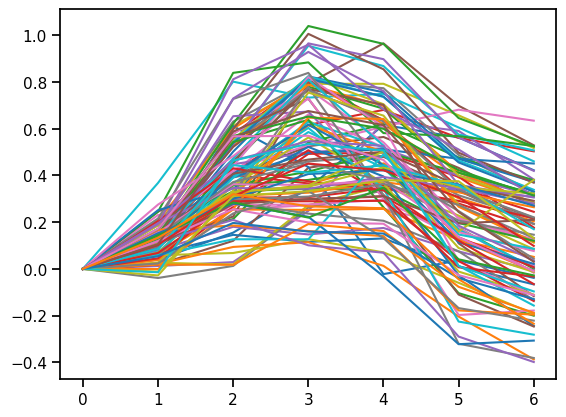

In [9]:
#Li-trans
fig, ax = plt.subplots()

atoms_for_training_NEB_transition_states = []
H_o_M_for_training_NEB_transition_states = []
paths_for_training_NEB_transition_states = []

# the ones generated manually (0250, 0500, 0750)
paths_for_training_NEB_transition_states  = glob.glob("/nfshome/sadowski/work/LiNiO2_data_base_Sabrina/DFT_database/NEBs_Marcel/0250/NEB_*_finished/run_final")
paths_for_training_NEB_transition_states += glob.glob("/nfshome/sadowski/work/LiNiO2_data_base_Sabrina/DFT_database/NEBs_Marcel/0500/NEB_*_finished/run_final")
paths_for_training_NEB_transition_states += glob.glob("/nfshome/sadowski/work/LiNiO2_data_base_Sabrina/DFT_database/NEBs_Marcel/0750/NEB_*_finished/run_final")

# the random ones
paths_for_training_NEB_transition_states += glob.glob("/nfshome/sadowski/work/LiNiO2_data_base_Sabrina/DFT_database/NEBs_Marcel/0*random*/02_odh/NEB_*/run_final")
paths_for_training_NEB_transition_states += glob.glob("/nfshome/sadowski/work/LiNiO2_data_base_Sabrina/DFT_database/NEBs_Marcel/0*random*/03_tsh/NEB_*/run_final")
paths_for_training_NEB_transition_states += glob.glob("/nfshome/sadowski/work/LiNiO2_data_base_Sabrina/DFT_database/NEBs_Marcel/0*random*/04_double_tsh/NEB_*/run_final")

# Iterate over all run_final folders
for path in paths_for_training_NEB_transition_states:
    
    # Check the energy along the path. Use initial and final energies from the corresponding relaxed structures + the last steps of the 
    # optimized intermediate images
    energies = []
    energies.append(ASEread(path.replace("run_final", "OUTCAR_initial_image")).get_potential_energy())
    for i in ["01", "02", "03", "04", "05"]:
        energies.append(ASEread(f"{path}/{i}/OUTCAR").get_potential_energy())
    energies.append(ASEread(path.replace("run_final", "OUTCAR_final_image")).get_potential_energy())
    ax.plot([0,1,2,3,4,5,6], np.array(energies)-energies[0])
    
    # For "Proper" paths, there should be maximum in energy !between! initial and final paths... ignore those where this is not the case
    index_highest_energy = energies.index(max(energies))
    
    if index_highest_energy == 0 or index_highest_energy == 6:
        print(f"Ignore {path}\n  ---> image {index_highest_energy} has highest energy!")
    
    else:    
        # get the interpolated middle points of the initially created, straight odh-type path to be used as ideal position for the CE training
        ideal_TS_structure_file = glob.glob(path.replace("run_final", "run01*/03/POSCAR_orig_linear_interpolation"))
        if len(ideal_TS_structure_file) == 0:                # For ODH-type jumps there is no POSCAR_orig_linear_interpolation
            ideal_TS_structure_file = glob.glob(path.replace("run_final", "run01*/03/POSCAR"))
        ideal_TS_atoms = ASEread(ideal_TS_structure_file[0])
     
        atoms_for_training_NEB_transition_states.append(ideal_TS_atoms)
        
        # Compute heat of mixing per atom and append to list
        Li_count = ideal_TS_atoms.get_chemical_symbols().count("Li")
        O_count  = ideal_TS_atoms.get_chemical_symbols().count("O")
        H_o_M    = max(energies) - Li_count * E_ref_LiNiO2_per_O2 - (O_count/2-Li_count) * E_ref_NiO2_per_O2
        H_o_M_for_training_NEB_transition_states.append( H_o_M / len(ideal_TS_atoms) )
        
    


## Combine data

In [10]:
# combine the structures 
train_structures = ( atoms_for_training_from_own_enumerated_structures 
                    + atoms_for_training_from_Markus_low_energy_structures
                    + atoms_for_training_NEB_initial_and_final_images 
                    + atoms_for_training_NEB_transition_states
             )

# ... and energies
train_H_o_M      = ( H_o_M_for_training_from_own_enumerated_structures 
                     + H_o_M_for_training_from_Markus_low_energy_structures
                     + H_o_M_for_training_NEB_initial_and_final_images 
                     + H_o_M_for_training_NEB_transition_states
             )

# to be able to retrieve problematic files, keep the paths
file_location = ( outcars_for_training_from_own_enumerated_structures 
                + outcars_for_training_from_Markus_low_energy_structures 
                + outcars_for_training_NEB_initial_and_final_images 
                + paths_for_training_NEB_transition_states
                )

# Fitting of just the Li sublattice

In [11]:
# Read R-3m model of LiNiO2 in R-3m symmetry with transition states
prim_TS = ASEread("/nfshome/sadowski/work/LiNiO2_Sabrina/37_CE_for_Li_diffusion/00_LNO_R-3m.vasp")

print(prim_TS)
print(prim_TS.get_chemical_symbols())

Atoms(symbols='LiNiO2', pbc=True, cell=[[2.8428983688, 0.0, 0.0], [-1.4214491844, 2.4620222078, 0.0], [1.42145, 0.82067, 4.71521]])
['Li', 'Ni', 'O', 'O']


In [12]:
# Assign chemical symbols
chemical_symbols_TS= [['Li', 'X', 'Ti'],   # Li sublattice will contain: Li and Vacancies (=X), later also Ni
                      ['Ni'],       # Ni sublattice will not be changed
                      ['O'],        # O  sublattice will not be changed
                      ['O']]

<font color='red'>  deleted first fitting with CVE</font>

<font color='red'> deleted traing of ardr_lambda </font>
just left the setting of the Clusterspace

<font color='red'> deleted code cell for calculating with the model with respect to the trained structure </font>
kept initalization of data[] (without predicted_energy)

<font color='red'> deleted code cell for plotting the ardr_lambda fitting vs reference data with respect to the diffrent data sets </font>

# Optimizing CE

## finding cutoffs
list possile cutoffs and define standard variables

In [19]:
position_tolerance = 0.01
symprec = 0.01
tol_positions=0.05

fit_methods = ['ardr-lambda', 'lasso', 'bayesian-ridge', 'elasticnet', 'omp', 'ridge',]

## comparing fitting algorithms

In [20]:
# Store stuff for later use

from icet.tools import ConvexHull

data = {'concentration': [], 'reference_energy': [], 'hull_energy': [], 'file_location': []}

# Go trough all the data
for h_o_m, location in zip( train_H_o_M, file_location):
    
    try:
        
        atoms = ASEread(location, index=":")
    
        # Compute total heat of mixing 
        Li_count = atoms[-1].get_chemical_symbols().count("Li")
        O_count  = atoms[-1].get_chemical_symbols().count("O")
        # Compute Li concentration
        data['concentration'].append(Li_count/(O_count/2))

        # Add original energy to dictthe factor of 1e3 serves to convert from eV/atom to meV/atom
        data['reference_energy'].append(1e3 * h_o_m)
        
        # keep the file location to allow parsing
        data['file_location'].append(location)
    
    # Catch errors in case something goes wrong
    except Exception as err:
        print(f"Problems with {file_location}")
        print(f"Original Error Message:\n {err}\n")

hull = ConvexHull(data['concentration'], data['reference_energy'])
data['hull_energy'] = []
for concentration in data['concentration']:
    data['hull_energy'].append(hull.get_energy_at_convex_hull(concentration))

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [21]:
# jupyter_stop('dont rerun all CE creation if not necessary')
hull_distances = {}
ce_lib = {}
cve = {}
predict = {}

save_file = prevent_overwrite('/nfshome/winkelmann/ARL/tmp/compare_fitting_algorithms_titanTS')
file_format = '%14s,\t%20s,\t%20s,\t%20s,\t%16s,\t%16s' + os.linesep
file = open(save_file,'w')
file.write(file_format % ('fit_method', 'RMSE_validation', 'RMSE_train', 'hull_distance', 'comp_time', 'use_time'))
file.close()

for fit_method in fit_methods:
    start_time = pytime.time()
    cutoffs = [8.09,8.09,8.09]
    
    # convert structures and energy to vectors    
    (A, y), mapped_structures = get_fit_data(prim=prim_TS, chemical_symbols=chemical_symbols_TS, cutoffs=cutoffs,
                                             energy_list=train_H_o_M, 
                                             atoms_ref_list=train_structures, 
                                             outcar_list=file_location, 
                                             position_tolerance=position_tolerance, symprec=symprec, tol_positions=tol_positions)
    
    if fit_method == 'ardr-lambda':
        cve[fit_method] = CrossValidationEstimator((A, y), fit_method='ardr', threshold_lambda=1000, validation_method='shuffle-split', n_splits=10)
    elif fit_method == 'ardr-lineScan':
        cve[fit_method] = CrossValidationEstimator((A, y), fit_method='ardr', line_scan=True, validation_method='shuffle-split', n_splits=10)
    else:
        cve[fit_method] = CrossValidationEstimator((A, y), fit_method=fit_method, validation_method='shuffle-split', n_splits=10)
    cve[fit_method].validate()
    cve[fit_method].train()
        
    # set up Clusterspace
    cs = ClusterSpace(structure=prim_without_TS, cutoffs=cutoffs, chemical_symbols=chemical_symbols_without_TS, position_tolerance=position_tolerance, symprec=symprec)  
    
    ce_lib[fit_method] = ClusterExpansion(cluster_space=cs, parameters=cve[fit_method].parameters, metadata=cve[fit_method].summary)
    ce_lib[fit_method].write('/nfshome/winkelmann/ARL/tmp/mixing_energy_titanTS_%s.ce' % fit_method)
    comp_time = pytime.time() - start_time
    
    predict[fit_method] = []
    start_time = pytime.time()
    for mapped_structure in mapped_structures:
        predict[fit_method].append(1e3 * ce_lib[fit_method].predict(mapped_structure))
    use_time = pytime.time() - start_time
    
    #calculating distance to hull
    hull_distances[fit_method] = np.absolute(np.subtract(predict[fit_method], data['hull_energy']))
    file = open(save_file,'a')
    file.write(file_format % (fit_method, cve[fit_method].rmse_validation, cve[fit_method].rmse_train, sum(hull_distances[fit_method]), comp_time, use_time))
    file.close()
    
file = open(save_file,'a')
hull_distances['reference'] = np.absolute(np.subtract(data['hull_energy'], data['reference_energy']))
file.write(file_format % ('reference','','',sum(hull_distances['reference']),'',''))
file.close()

Computing structure 0 of 984 (0.0%)   2025-02-06 18:38:49.903737
Computing structure 98 of 984 (10.0%)   2025-02-06 18:38:52.560293
Computing structure 196 of 984 (19.9%)   2025-02-06 18:38:55.857963
Computing structure 294 of 984 (29.9%)   2025-02-06 18:38:58.947688
Computing structure 392 of 984 (39.8%)   2025-02-06 18:39:02.239294
Computing structure 490 of 984 (49.8%)   2025-02-06 18:39:05.522842
Computing structure 588 of 984 (59.8%)   2025-02-06 18:39:09.587586
Computing structure 686 of 984 (69.7%)   2025-02-06 18:39:14.167547
Computing structure 784 of 984 (79.7%)   2025-02-06 18:39:26.176942
Computing structure 882 of 984 (89.6%)   2025-02-06 18:39:39.981504
icet: WARNING  Large maximum relaxation distance (1.33278 Angstrom). Consider excluding this structure when training a cluster expansion.
icet: WARNING  An atom was approximately equally far from its two closest sites.
icet: WARNING  Large maximum relaxation distance (1.39378 Angstrom). Consider excluding this structure wh

KeyboardInterrupt: 

### plotting and comparing results

In [ ]:
# jupyter_stop('if Ce arent rerunning no sense in plotting them')
%%capture
sorted_concentration_indices = np.argsort(data['concentration'])
pdf = PdfPages('/nfshome/winkelmann/ARL/tmp/compare_fitting_algorithms_titanTS.pdf')

for key, value in predict.items():
    fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(18,9), dpi=300)

    # ax1 = HOM (predict & reference) & hull

    ax1.set_title('heat of mixing (%s)' % key)
    ax1.set_xlabel('x in Li$_x$')
    ax1.set_ylabel('Mixing energy (meV/atom)')

    ax1.plot(np.array(data['concentration'])[sorted_concentration_indices],
             np.array(data['hull_energy'])[sorted_concentration_indices], label='convex hull of reference')
    ax1.scatter(data['concentration'], data['reference_energy'], marker='o', label='reference')
    ax1.scatter(data['concentration'], value, marker='x', label=key)
    ax1.legend()

    fig.savefig('/nfshome/winkelmann/ARL/save/titanTS_data/extra_plots/convexHull_titanTS_%s.png' %(fit_method))

    # ax2 = reference vs predict (color coded for diffrence hull
    fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(18,9), dpi=300)
    ax2.set_title('prediction error plot (%s)' % key)
    ax2.set_xlabel('Prediction (mev/atom)')
    ax2.set_ylabel('reference (meV/atom)')
    
    img1 = ax2.scatter(value, data['reference_energy'], c=hull_distances[key], cmap='jet')
    cb = fig.colorbar(img1)
    cb.set_label('distance to hull (ref)')    
    
    ax2.plot(ax2.get_xlim(), ax2.get_ylim(), ls='--', color='black')  # plotting a diagonal line for reference
    fig.savefig('/nfshome/winkelmann/ARL/save/titanTS_data/extra_plots/error_titanTS_%s.png' %(fit_method))
    pdf.savefig(figure=fig, bbox_inches='tight')
pdf.close()

## via Convex Hull

In [ ]:
#reading existing CE's

predict_no_opt = {}
hull_distances = {'opt_cve':{}, 'opt':{}, 'no_opt':{}, 'reference':[]}
ce_lib = {}

for fit_method in fit_methods:
    ce_lib[fit_method] = ClusterExpansion.read('/nfshome/winkelmann/ARL/tmp/mixing_energy_no_TS_%s.ce' % fit_method)
hull_distances['reference'] = np.absolute(np.subtract(data['hull_energy'], data['reference_energy']))
weights = []
for distance in hull_distances['reference']:
    if distance != 0:
        weights.append(1/distance)
    else: 
        weights.append(0)
max_weight = max(weights)
for w in weights:
    if w == 0:
        w = max_weight * 1.1 #number makes no noticable diffrence (weights should be small but this should be the highest)
weights = np.array(weights)

In [ ]:
jupyter_stop('dont rerun all CE creation if not necessary')
# optimizing CE
from trainstation import Optimizer

opt = {}
ce_opt_lib = {}
predict_opt = {}
save_file = prevent_overwrite('/nfshome/winkelmann/ARL/tmp/compare_fitting_algorithms_optimized_titanTS')
file_format = '%14s,\t%20s,\t%20s,\t%20s,\t%16s,\t%16s' + os.linesep
file = open(save_file,'w')
file.write(file_format % ('fit_method', 'RMSE_validation', 'RMSE_train', 'hull_distance', 'comp_time', 'use_time'))
file.close()

for fit_method in fit_methods:  
    start_time = pytime.time()
    cutoffs = best_cutoffs[fit_method]
        
    #calculate weighted ClusterVectors and energies  
    print(fit_method)
    (A, y), mapped_structures = get_fit_data(prim=prim_without_TS, chemical_symbols=chemical_symbols_without_TS, cutoffs=cutoffs, 
                                             energy_list=train_H_o_M, 
                                             atoms_ref_list=train_structures, 
                                             outcar_list=file_location, 
                                             position_tolerance=position_tolerance, symprec=symprec, tol_positions=tol_positions)
    
    A_weighted = np.multiply(A, weights.reshape(-1,1))
    y_weighted = np.multiply(y, weights)    
    if fit_method == 'ardr-lambda':
        opt[fit_method] = Optimizer((A_weighted, y_weighted), fit_method='ardr', threshold_lambda=1000)
    elif fit_method == 'ardr-lineScan':
        opt[fit_method] = Optimizer((A_weighted, y_weighted), fit_method='ardr', line_scan=True)
    else:
        opt[fit_method] = Optimizer((A_weighted, y_weighted), fit_method=fit_method)
    opt[fit_method].train()
    
    # set up Clusterspace
    cs = ClusterSpace(structure=prim_without_TS, cutoffs=cutoffs, chemical_symbols=chemical_symbols_without_TS, position_tolerance=position_tolerance, symprec=symprec)  
    
    ce_opt_lib[fit_method] = ClusterExpansion(cluster_space=cs, parameters=opt[fit_method].parameters, metadata=opt[fit_method].summary)
    ce_opt_lib[fit_method].write('/nfshome/winkelmann/ARL/tmp/mixing_energy_opt_no_TS_%s.ce' % fit_method)
    comp_time = pytime.time() - start_time
    
    predict_opt[fit_method] = []
    start_time = pytime.time()
    for mapped_structure in mapped_structures:
        predict_opt[fit_method].append(1e3 * ce_opt_lib[fit_method].predict(mapped_structure))
    use_time = pytime.time() - start_time

    #calculating distance to hull
    hull_distances['opt'][fit_method] = np.absolute(np.subtract(data['hull_energy'], predict_opt[fit_method]))
        
    file = open(save_file,'a')
    file.write(file_format % (fit_method, opt[fit_method].rmse_test, opt[fit_method].rmse_train, sum(hull_distances['opt'][fit_method]), comp_time, use_time))
    file.close()
file = open(save_file,'a')
file.write(file_format % ('reference','','',sum(hull_distances['reference']),'',''))
file.close()

In [ ]:
##read created CE's

ce_opt_lib = {}
predict_opt = {}
mapped_structures = get_mapped_structures(prim=prim_without_TS, atoms_ref_list=train_structures, tol_positions=tol_positions)
for fit_method in fit_methods:
    ce_opt_lib[fit_method] = ClusterExpansion.read('/nfshome/winkelmann/ARL/tmp/mixing_energy_opt_no_TS_%s.ce' % fit_method)
    predict_opt[fit_method] = []
    for mapped_structure in mapped_structures:
        predict_opt[fit_method].append(1e3 * ce_opt_lib[fit_method].predict(mapped_structure))
    
    #calculating distance to hull
    hull_distances['opt'][fit_method] = np.absolute(np.subtract(data['hull_energy'], predict_opt[fit_method]))#sort by concentration for hull plotting
sorted_concentration_indices = np.argsort(data['concentration'])
#calculating predictions of normal CE for later fitting
for fit_method in fit_methods:
    predict_no_opt[fit_method] = []
    hull_distances['no_opt'] = {}
    for mapped_structure in mapped_structures:
        predict_no_opt[fit_method].append(1e3 * ce_lib[fit_method].predict(mapped_structure))
    
    #calculating distance to hull
    hull_distances['no_opt'][fit_method] = np.absolute(np.subtract(predict_no_opt[fit_method], data['hull_energy']))
    
    

In [ ]:
concentration_list = []
for concentration in data['concentration']:
    if not concentration in concentration_list:
        concentration_list.append(concentration)

concentration_list.sort()
concentration_eval = {}
for concentration in concentration_list:
    concentration_eval[concentration] = 0

for concentration in data['concentration']:
    concentration_eval[concentration] += 1
    
for concentration in concentration_eval:
    if concentration_eval[concentration] < 10:
        print(concentration, concentration_eval[concentration])

In [ ]:
%%capture

pdf = PdfPages('/nfshome/winkelmann/ARL/tmp/compare_fitting_algorithms_opt_titanTS.pdf')
for key, value in predict_opt.items():
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18,9))

    # ax1 = HOM (predict & reference) & hull

    ax1.set_title('heat of mixing (%s)' % key)
    ax1.set_xlabel('x in Li$_x$')
    ax1.set_ylabel('Mixing energy (meV/atom)')

    ax1.plot(np.array(data['concentration'])[sorted_concentration_indices],
             np.array(data['hull_energy'])[sorted_concentration_indices], label='convex hull of reference')
    ax1.scatter(data['concentration'], data['reference_energy'], marker='o', label='reference')
    ax1.scatter(data['concentration'], predict_no_opt[key], marker='x', label=key)
    ax1.scatter(data['concentration'], value, marker='+', label='%s_opt' % key)
    ax1.legend()
    
    
    # ax2 = reference vs predict (color coded for diffrence hull

    ax2.set_title('prediction error plot (%s)' % key)
    ax2.set_xlabel('Prediction (mev/atom)')
    ax2.set_ylabel('reference (meV/atom)')
    
    img1 = ax2.scatter(value, data['reference_energy'], c=hull_distances['opt'][key], marker='+', cmap='jet')
    cb = fig.colorbar(img1)
    cb.set_label('distance to hull (opt)')    
    
    ax2.plot(ax2.get_xlim(), ax2.get_ylim(), ls='--', color='black')  # plotting a diagonal line for reference
    pdf.savefig(figure=fig, bbox_inches='tight')
pdf.close()

## with CrossValidationOptimizer instead of simple Optimizer

In [ ]:
opt_cve = {}
ce_opt_cve_lib = {}
predict_opt_cve = {}
save_file = prevent_overwrite('/nfshome/winkelmann/ARL/tmp/compare_fitting_algorithms_optimized_cve_titanTS')
file_format = '%14s,\t%20s,\t%20s,\t%20s,\t%16s,\t%16s' + os.linesep
file = open(save_file,'w')
file.write(file_format % ('fit_method', 'RMSE_validation', 'RMSE_train', 'hull_distance', 'comp_time', 'use_time'))
file.close()

for fit_method in fit_methods:
    start_time = pytime.time()
    cutoffs = best_cutoffs[fit_method]
        
    #calculate weighted ClusterVectors and energies   
    (A, y), mapped_structures = get_fit_data(prim=prim_without_TS, chemical_symbols=chemical_symbols_without_TS, cutoffs=cutoffs, 
                                             energy_list=train_H_o_M, 
                                             atoms_ref_list=train_structures, 
                                             outcar_list=file_location, 
                                             position_tolerance=position_tolerance, symprec=symprec, tol_positions=tol_positions)

    A_weighted = np.multiply(A, weights.reshape(-1,1))
    y_weighted = np.multiply(y, weights)    
    if fit_method == 'ardr-lambda':
        opt_cve[fit_method] = CrossValidationEstimator((A_weighted, y_weighted), fit_method='ardr', threshold_lambda=1000)
    elif fit_method == 'ardr-lineScan':
        opt_cve[fit_method] = CrossValidationEstimator((A_weighted, y_weighted), fit_method='ardr', line_scan=True)
    else:
        opt_cve[fit_method] = CrossValidationEstimator((A_weighted, y_weighted), fit_method=fit_method)
    opt_cve[fit_method].validate()
    opt_cve[fit_method].train()
    
    # set up Clusterspace
    cs = ClusterSpace(structure=prim_without_TS, cutoffs=cutoffs, chemical_symbols=chemical_symbols_without_TS, position_tolerance=position_tolerance, symprec=symprec)  
    
    ce_opt_cve_lib[fit_method] = ClusterExpansion(cluster_space=cs, parameters=opt_cve[fit_method].parameters, metadata=opt_cve[fit_method].summary)
    ce_opt_cve_lib[fit_method].write('/nfshome/winkelmann/ARL/tmp/mixing_energy_opt_cve_no_TS_%s.ce' % fit_method)
    comp_time = start_time - pytime.time()
    
    predict_opt_cve[fit_method] = []
    start_time = pytime.time()
    for mapped_structure in mapped_structures:
        predict_opt_cve[fit_method].append(1e3 * ce_opt_lib[fit_method].predict(mapped_structure))
    use_time = start_time - pytime.time()
    
    #calculating distance to hull
    hull_distances['opt_cve'][fit_method] = np.absolute(np.subtract(predict_opt_cve[fit_method], data['hull_energy']))
    
    file = open(save_file,'a')
    file.write(file_format % (fit_method, opt_cve[fit_method].rmse_validation, opt_cve[fit_method].rmse_train, sum(hull_distances['opt_cve'][fit_method]), comp_time, use_time))
    file.close()
file = open(save_file,'a')
file.write(file_format % ('reference','','',sum(hull_distances['reference']),'',''))
file.close()

In [ ]:
%%capture
pdf = PdfPages('/nfshome/winkelmann/ARL/tmp/compare_fitting_algorithms_opt_cve_titanTS.pdf')

for key, value in predict_opt_cve.items():
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18,9))

    # ax1 = HOM (predict & reference) & hull

    ax1.set_title('heat of mixing (%s)' % key)
    ax1.set_xlabel('x in Li$_x$')
    ax1.set_ylabel('Mixing energy (meV/atom)')

    ax1.plot(np.array(data['concentration'])[sorted_concentration_indices],
             np.array(data['hull_energy'])[sorted_concentration_indices], label='convex hull of reference')
    ax1.scatter(data['concentration'], data['reference_energy'], marker='o', label='reference')
    ax1.scatter(data['concentration'], predict_opt[key], marker='x', label=key)
    ax1.scatter(data['concentration'], value, marker='+', label='%s_opt_cve' % key)
    ax1.scatter(data['concentration'], predict_opt_cve[key], marker='2', label='%s_opt' % key)
    ax1.legend()
    
    
    # ax2 = reference vs predict (color coded for diffrence hull

    ax2.set_title('prediction error plot (%s)' % key)
    ax2.set_xlabel('Prediction (mev/atom)')
    ax2.set_ylabel('reference (meV/atom)')
    
    img1 = ax2.scatter(value, data['reference_energy'],marker='x', c=hull_distances['opt_cve'][key], cmap='jet')
    cb1 = fig.colorbar(img1)
    cb1.set_label('distance to hull (opt_cve)')  
    img2 = ax2.scatter(predict_opt[key],data['reference_energy'],marker='+', c=hull_distances['opt'][key], cmap='jet') 
    cb2 = fig.colorbar(img2)
    cb2.set_label('distance to hull (opt)')
    ax2.plot(ax2.get_xlim(), ax2.get_ylim(), ls='--', color='black')  # plotting a diagonal line for reference
    
    pdf.savefig(figure=fig, bbox_inches='tight')
pdf.close()

In [ ]:
%%capture

pdf = PdfPages('/nfshome/winkelmann/ARL/tmp/optimization_evolution.pdf')
for key, value in predict_opt_cve.items():
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=4, figsize=(36,9))

    # ax1 = HOM (reference) & hull

    ax1.set_title('heat of mixing (%s)' % key)
    ax1.set_xlabel('x in Li$_x$')
    ax1.set_ylabel('Mixing energy (meV/atom)')

    ax1.plot(np.array(data['concentration'])[sorted_concentration_indices],
             np.array(data['hull_energy'])[sorted_concentration_indices], label='convex hull of reference')
    ax1.scatter(data['concentration'], data['reference_energy'], marker='o', label='reference')
    ax1.legend()
    
    # ax2 = HOM (predict & reference) & hull

    ax2.set_title('heat of mixing (%s)' % key)
    ax2.set_xlabel('x in Li$_x$')
    ax2.set_ylabel('Mixing energy (meV/atom)')

    ax2.plot(np.array(data['concentration'])[sorted_concentration_indices],
             np.array(data['hull_energy'])[sorted_concentration_indices], label='convex hull of reference')
    ax2.scatter(data['concentration'], data['reference_energy'], marker='o', label='reference')
    ax2.scatter(data['concentration'], predict_no_opt[key], marker='x', label=key)
    ax2.legend()
    
    # ax3 = HOM (predict_opt & predict & reference) & hull

    ax3.set_title('heat of mixing (%s)' % key)
    ax3.set_xlabel('x in Li$_x$')
    ax3.set_ylabel('Mixing energy (meV/atom)')

    ax3.plot(np.array(data['concentration'])[sorted_concentration_indices],
             np.array(data['hull_energy'])[sorted_concentration_indices], label='convex hull of reference')
    ax3.scatter(data['concentration'], data['reference_energy'], marker='o', label='reference')
    ax3.scatter(data['concentration'], predict_no_opt[key], marker='x', label=key)
    ax3.scatter(data['concentration'], predict_opt[key], marker='+', label='%s_opt' % key)
    ax3.legend()
    
    # ax4 = HOM (predict_opt_cve & predict_opt & predict & reference) & hull

    ax4.set_title('heat of mixing (%s)' % key)
    ax4.set_xlabel('x in Li$_x$')
    ax4.set_ylabel('Mixing energy (meV/atom)')

    ax4.plot(np.array(data['concentration'])[sorted_concentration_indices],
             np.array(data['hull_energy'])[sorted_concentration_indices], label='convex hull of reference')
    ax4.scatter(data['concentration'], data['reference_energy'], marker='o', label='reference')
    ax4.scatter(data['concentration'], predict_no_opt[key], marker='x', label=key)
    ax4.scatter(data['concentration'], predict_opt[key], marker='x', label='%s_opt' % key)
    ax4.scatter(data['concentration'], value, marker='+', label='%s_opt_cve' % key)
    ax4.legend()
    

    pdf.savefig(figure=fig, bbox_inches='tight')
pdf.close()

In [ ]:
for fit_method in fit_methods:
    print(fit_method + ':\t' + str(sum(np.absolute(np.subtract(predict_opt_cve[fit_method], predict_opt[fit_method])))))